In [1]:
import numpy as np
import GPy
import GPyOpt
import math
from scipy.optimize import minimize, differential_evolution
from scipy.stats import norm, beta
import matplotlib.pyplot as plt

%matplotlib inline

In [285]:
from functionDoESpecial import functionDoESpecial, function_dimensions, function_names

In [295]:
f_name = 'allinit'

In [296]:
objective = lambda x: functionDoESpecial(x, f_name)

In [297]:
x = np.linspace(-2, 2, 100)
plt.plot(x, objective(x.reshape(-1, 1)))

IndexError: index 1 is out of bounds for axis 1 with size 1

In [289]:
xs = np.linspace(-1.5, 1.5, 100)
ys = np.linspace(-1.5, 1.5, 100)
xs, ys = np.meshgrid(xs, ys)

In [290]:
objective(np.dstack([xs, ys]).reshape(10000, 2)).reshape(100, 100)

array([[5.16528926, 5.1152016 , 5.06511395, ..., 3.41222139, 3.46230904,
        3.51239669],
       [5.1152016 , 5.06559965, 5.01599769, ..., 3.37913318, 3.42873513,
        3.47833709],
       [5.06511395, 5.01599769, 4.96688144, ..., 3.34604497, 3.39516123,
        3.44427749],
       ...,
       [3.41222139, 3.37913318, 3.34604497, ..., 2.25413413, 2.28722234,
        2.32031054],
       [3.46230904, 3.42873513, 3.39516123, ..., 2.28722234, 2.32079624,
        2.35437015],
       [3.51239669, 3.47833709, 3.44427749, ..., 2.32031054, 2.35437015,
        2.38842975]])

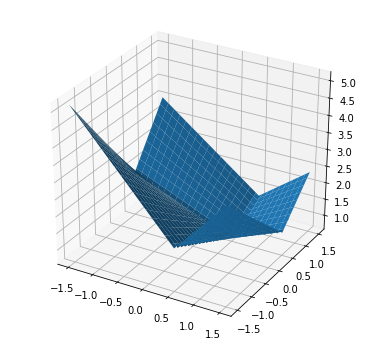

In [291]:
fig = plt.figure(figsize=(14,6))

ax = fig.add_subplot(1, 2, 1, projection='3d')

p = ax.plot_surface(xs, ys, objective(np.dstack([xs, ys]).reshape(10000, 2)).reshape(100, 100), rstride=4, cstride=4, linewidth=0)

In [203]:
def inverse_sigmoid(x):
    
    return np.log(x/(1-x))

In [204]:
def value_generator(x, n_trials=20):
    values = objective(x)
    Ysim = np.random.binomial(n_trials, values)
    return Ysim.reshape(-1, 1)

In [269]:
low = -2
high = 2
dims = 3
lower_bounds = [low] * dims
upper_bounds = [high] * dims

In [270]:
space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)

In [271]:
init_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 5)

In [272]:
objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
argmin = differential_evolution(objective, [(low, high)] * dims, tol=0.001).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(low, high)] * dims, tol=0.001).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
objective = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

In [228]:
def expected_improvement(mean_values, std_values, opt_value):
    improvement = (opt_value - mean_values).ravel()
    std_values = std_values.ravel()
    EI = improvement * norm.cdf(improvement / std_values) + std_values * norm.pdf(improvement / std_values)
    return EI

def expected_improvement_approx(mean_values, std_values, opt_value, binomial, n_sample=500):
    
    EI = []
    
    for mean, std in zip(mean_values, std_values):
        samples = np.random.normal(mean, std, n_sample)
        samples = samples[samples<opt_value]
        EI.append(np.mean(binomial.gp_link.transf(opt_value) - binomial.gp_link.transf(samples)))
        
    return np.array(EI)

def fidelity_decision(low_trials, successful, min_value, treshold_proba=0.5):
    
    n = low_trials
    k = successful
    posterior_ps = beta(k+1, n-k+1)
    
    if 1 - posterior_ps.cdf(min_value) > treshold_proba:
        return True
    return False

def get_new_point(model, lower_bounds, upper_bounds, data=None,
                  multistart=10, seed=None, method='gaussian', n_sample=500):
    """
    Parameters:
        model - GP model of the objective function
        lower_bounds, upper_bounds - array-like, lower and upper bounds of x
        data - tuple(x_training, y_training)
        multistart - number of multistart runs
        seed - np.random.RandomState
        method - gaussian or approximated
        n_sample - number of points for approximated EI calculation
    Returns
        tuple - argmin of the objective function and min value of the objective
    """
    if seed is not None:
        np.random.seed(seed)
    lower_bounds = np.array(lower_bounds).reshape(1, -1)
    upper_bounds = np.array(upper_bounds).reshape(1, -1)

    random_initial_points = np.random.uniform(lower_bounds, upper_bounds, size=(multistart, lower_bounds.shape[1]))

    def objective(x):
        
        if x.ndim == 1:
            x = x.reshape(1, -1)
            
        if method=='gaussian':
            mean_values, variance = model.predict(x)
            std_values = np.sqrt(variance)
            
            return -expected_improvement(mean_values, std_values, data[1].min())
        
        elif method=='laplace':
            mean_values, variance = model._raw_predict(x)
            std_values = np.sqrt(variance)
            
            return -expected_improvement_approx(mean_values, std_values, data[1].min(), GPy.likelihoods.Binomial(), n_sample)

    best_result = None
    best_value = np.inf
    for random_point in random_initial_points:
        
        try:
            result = minimize(objective, random_point, method='L-BFGS-B',
                              bounds=np.vstack((lower_bounds, upper_bounds)).T)
            if result.fun < best_value:
                best_value = result.fun
                best_result = result
        except:
            print("bad point")

    return best_result.x, best_result.fun

def optimization_step(training_points, training_values, objective, trials=None, n_trials=20,
                      lower_bounds=None, upper_bounds=None, kernel=GPy.kern.RBF(1), method='gaussian'):
    
    if trials.ndim != 2:
        trials = trials.reshape(-1, 1)
    
    if method=='gaussian':
        model = GPy.models.GPRegression(training_points, training_values / trials, kernel)
        
    else:
        binomial = GPy.likelihoods.Binomial()
        model = GPy.core.GP(training_points, training_values, kernel=GPy.kern.RBF(1), 
                              Y_metadata={'trials': trials},
                              inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                              likelihood=binomial)
    model.optimize_restarts(num_restarts=10, verbose=False)
        
    new_point, criterion_value = get_new_point(model, data=(training_points, training_values),
                                               lower_bounds=lower_bounds, upper_bounds=upper_bounds, method=method)
    
    new_point = new_point.reshape(1, -1)
    training_points = np.vstack([training_points, new_point])
    trials = np.vstack([trials, np.array([[n_trials]])])
    training_values = np.vstack([training_values, np.asarray(objective(new_point, n_trials)).reshape(1, -1)])
        
    return training_points, training_values, trials, model

Gaussian inference

In [273]:
X_g = init_design
Y_g = value_generator(X_g).reshape(-1, 1)
trials_g = np.ones(len(X_g)).reshape(-1, 1) * 20

m_g = GPy.models.GPRegression(X_g, Y_g/trials_g, GPy.kern.RBF(1))

In [260]:
X_g, Y_g, trials_g, m_g = optimization_step(X_g, Y_g, value_generator, lower_bounds=lower_bounds,\
                                            upper_bounds=upper_bounds, trials=trials_g)

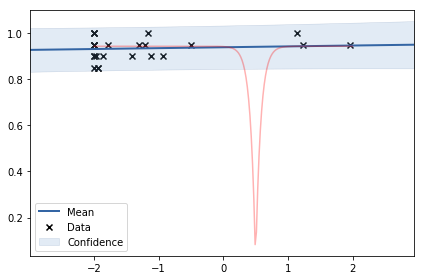

In [131]:
m_g.plot()
plt.plot()

p = np.linspace(lower_bounds[0], upper_bounds[0], 200).reshape(-1, 1)
plt.plot(p, objective(p), color='red', alpha=0.3)

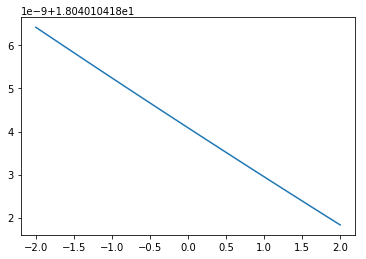

In [127]:
means, variances = m_g.predict(np.linspace(lower_bounds[0], upper_bounds[0],100).reshape(-1,1))
minimum = Y_g.min()
eis = expected_improvement(means, np.sqrt(variances), minimum)
plt.plot(np.linspace(lower_bounds[0], upper_bounds[0], 100), eis)

In [274]:
model_mins_g = []
model_mins_g.append(np.min(m_g.predict(X_g)[0]))

In [275]:
for i in range(20):
    X_g, Y_g, trials_g, m_g = optimization_step(X_g, Y_g, value_generator, lower_bounds=lower_bounds,\
                                                upper_bounds=upper_bounds, trials=trials_g)
    model_mins_g.append(np.min(m_g.predict(X_g)[0]))

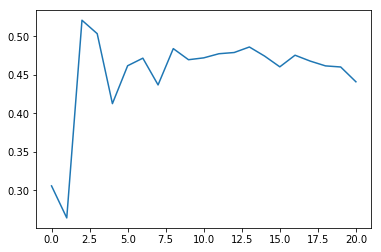

In [276]:
plt.plot(model_mins_g)

In [ ]:
performance_per_n_trials = []

for n_trials in [20, 40, 60, 80]:
    
    stat_per_attempt = []
    
    for n_attempts in range(7):
        
        X_g = init_design
        Y_g = value_generator(X_g).reshape(-1, 1)
        trials_g = np.ones(len(X_g)).reshape(-1, 1) * n_trials

        m_g = GPy.models.GPRegression(X_g, Y_g/trials_g, GPy.kern.RBF(1))
        model_mins_g = []
        model_mins_g.append(np.min(m_g.predict(X_g)[0]))
        
        for n_iteration in range(40):
            
            X_g, Y_g, trials_g, m_g = optimization_step(X_g, Y_g, value_generator,\
                                                        lower_bounds=lower_bounds,\
                                                        upper_bounds=upper_bounds,\
                                                        trials=trials_g,
                                                        n_trials=n_trials)
            model_mins_g.append(np.min(m_g.predict(X_g)[0]))
        
        stat_per_attempt.append(model_mins_g)
        
    performance_per_n_trials.append(stat_per_attempt)
    
performance_per_n_trials = np.array(performance_per_n_trials)

In [ ]:
plt.plot(performance_per_n_trials[0].mean(axis=0), label='20')
plt.plot(performance_per_n_trials[1].mean(axis=0), label='40')
plt.plot(performance_per_n_trials[2].mean(axis=0), label='60')
plt.plot(performance_per_n_trials[3].mean(axis=0), label='80')
plt.legend()

In [ ]:
performance_per_n_trials[1]

Approximated inference

In [277]:
X_l = init_design
Y_l = value_generator(X_l).reshape(-1, 1)
trials_l = np.ones(X_l.shape[0]).reshape(-1, 1) * 20

m_l = GPy.core.GP(X_l, Y_l, kernel=GPy.kern.RBF(1), 
                  Y_metadata={'trials': trials_l},
                  inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                  likelihood=GPy.likelihoods.Binomial())

In [113]:
X_l, Y_l, trials_l, m_l = optimization_step(X_l, Y_l, value_generator, lower_bounds=lower_bounds,\
                                            upper_bounds=upper_bounds, trials=trials_l, method='laplace')

In [ ]:
m_l.optimize_restarts(num_restarts=20)

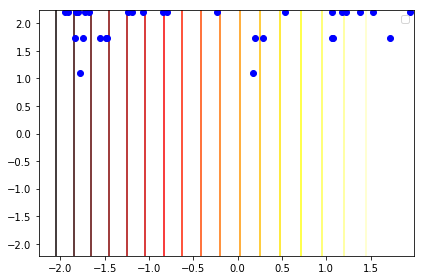

In [167]:
m_l.plot_f()
plt.plot(X_l, inverse_sigmoid(value_generator(X_l) / trials_l), 'bo')

In [ ]:
plt.plot(X_l, value_generator(X_l) / trials_l, 'bo')
p = np.linspace(-5, 5, 200).reshape(-1, 1)
plt.plot(p, objective(p), color='red', alpha=0.3)

In [278]:
lik = GPy.likelihoods.Bernoulli()
model_mins_l = []
model_mins_l.append(lik.gp_link.transf(np.min(m_l._raw_predict(X_l)[0])))

In [279]:
for i in range(20):
    X_l, Y_l, trials_l, m_l = optimization_step(X_l, Y_l, value_generator, lower_bounds=lower_bounds,\
                                                upper_bounds=upper_bounds, trials=trials_l, method='laplace')
    model_mins_l.append(lik.gp_link.transf(np.min(m_l._raw_predict(X_l)[0])))

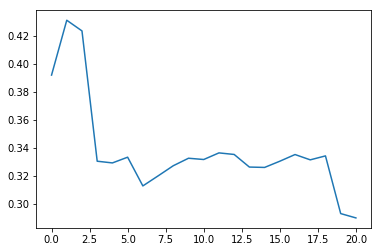

In [280]:
plt.plot(model_mins_l)

In [ ]:
performance_per_n_trials_l = []

for n_trials in [20, 60]:
    
    stat_per_attempt = []
    
    for n_attempts in range(7):
        
        X_l = init_design
        Y_l = value_generator(X_l).reshape(-1, 1)
        trials_l = np.ones(X_l.shape[0]).reshape(-1, 1) * n_trials

        m_l = GPy.core.GP(X_l, Y_l, kernel=GPy.kern.RBF(1), 
                          Y_metadata={'trials': trials_l},
                          inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                          likelihood=GPy.likelihoods.Binomial())
        
        lik = GPy.likelihoods.Bernoulli()
        model_mins_l = []
        model_mins_l.append(lik.gp_link.transf(np.min(m_l._raw_predict(X_l)[0])))
        
        for n_iteration in range(40):
            
            X_l, Y_l, trials_l, m_l = optimization_step(X_l, Y_l, value_generator,\
                                                        lower_bounds=lower_bounds,\
                                                        upper_bounds=upper_bounds,\
                                                        trials=trials_l, method='laplace',\
                                                        n_trials=n_trials)
            model_mins_l.append(lik.gp_link.transf(np.min(m_l._raw_predict(X_l)[0])))
        
        stat_per_attempt.append(model_mins_l)
        
    performance_per_n_trials_l.append(stat_per_attempt)
    
performance_per_n_trials_l = np.array(performance_per_n_trials_l)

In [ ]:
plt.plot(performance_per_n_trials_l[1].mean(axis=0))
plt.plot(performance_per_n_trials_l[0].mean(axis=0))

In [ ]:
plt.plot(performance_per_n_trials_l[1].mean(axis=0), label='Laplace')
plt.plot(performance_per_n_trials[2].mean(axis=0), label='GP')
plt.legend()

In [ ]:
plt.plot(performance_per_n_trials_l[0].mean(axis=0))
plt.plot(performance_per_n_trials[0].mean(axis=0))

Full experiment

In [ ]:
f_name='michalewicz' 
dims=3
n_iter=60
repeats=5
low=-2
high=2
init_design_amount=5
n_trials=20
proba_range=[0, 0.5, 1]
    
objective = lambda x: functionDoESpecial(x.reshape(1, -1), f_name)
if f_name in function_dimensions.keys():
    dims = function_dimensions[f_name]

lower_bounds = [low] * dims
upper_bounds = [high] * dims

space = []
for i in range(len(lower_bounds)):
    space.append({'name': 'x'+str(i), 'type': 'continuous', 'domain': (lower_bounds[i], upper_bounds[i])})

feasible_region = GPyOpt.Design_space(space=space)
init_design = GPyOpt.experiment_design.initial_design('random', feasible_region, init_design_amount)
#search max and min
argmin = differential_evolution(objective, [(low, high)] * dims).x
argmax = differential_evolution(lambda x: -1 * objective(x), [(low, high)] * dims).x
max_v = objective(argmax)
min_v = objective(argmin)
#normalize function
objective = lambda x: (functionDoESpecial(x, f_name) * 0.95 - min_v) / (max_v - min_v)

def value_generator(x, n_trials=n_trials):
    values = objective(x)
    Ysim = np.random.binomial(n_trials, values)
    return Ysim.reshape(-1, 1)

performance_per_n_trials_m = []

for proba in proba_range:

    stat_per_attempt = []

    for n_attempts in range(repeats):

        X_m = init_design
        Y_m = value_generator(X_m).reshape(-1, 1)
        trials_m = np.ones(X_m.shape[0]).reshape(-1, 1) * n_trials

        m_m = GPy.core.GP(X_m, Y_m, kernel=GPy.kern.RBF(1), 
                          Y_metadata={'trials': trials_m},
                          inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                          likelihood=GPy.likelihoods.Binomial())

        lik = GPy.likelihoods.Bernoulli()
        model_mins_m = []
        model_mins_m.append(lik.gp_link.transf(np.min(m_m._raw_predict(X_m)[0])))

        for n_iteration in range(n_iter):

            X_m, Y_m, trials_m, m_m = optimization_step(X_m, Y_m, value_generator,
                                                        lower_bounds=lower_bounds,
                                                        upper_bounds=upper_bounds,
                                                        trials=trials_m, method='laplace', 
                                                        treshold_proba=proba,
                                                        n_trials_low=n_trials, n_trials_high=n_trials)
            model_mins_m.append(lik.gp_link.transf(np.min(m_m._raw_predict(X_m)[0])))

        stat_per_attempt.append([np.array(model_mins_m), trials_m.reshape(-1, 1)])

    performance_per_n_trials_m.append(stat_per_attempt)

performance_per_n_trials_m = np.array(performance_per_n_trials_m)

mean_cost = performance_per_n_trials_m[1, :, 1].mean().mean()

def value_generator2(x, n_trials=mean_cost):
    values = objective(x)
    Ysim = np.random.binomial(n_trials, values)
    return Ysim.reshape(-1, 1)

stat_per_attempt = []
n_trials = mean_cost

for n_attempts in range(repeats):

    X_m = init_design
    Y_m = value_generator2(X_m).reshape(-1, 1)
    trials_m = np.ones(X_m.shape[0]).reshape(-1, 1) * n_trials

    m_m = GPy.core.GP(X_m, Y_m, kernel=GPy.kern.RBF(1), 
                      Y_metadata={'trials': trials_m},
                      inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                      likelihood=GPy.likelihoods.Binomial())

    lik = GPy.likelihoods.Bernoulli()
    model_mins_m = []
    model_mins_m.append(lik.gp_link.transf(np.min(m_m._raw_predict(X_m)[0])))

    for n_iteration in range(n_iter):

        X_m, Y_m, trials_m, m_m = optimization_step(X_m, Y_m, value_generator2,
                                                    lower_bounds=lower_bounds,
                                                    upper_bounds=upper_bounds,
                                                    trials=trials_m, method='laplace', 
                                                    treshold_proba=proba,
                                                    n_trials_low=n_trials, n_trials_high=n_trials)
        model_mins_m.append(lik.gp_link.transf(np.min(m_m._raw_predict(X_m)[0])))

    stat_per_attempt.append([np.array(model_mins_m), trials_m.reshape(-1, 1)])